In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.onnx
from library import banknote_dataset, train_flow

plt.style.use('ggplot')
DEVICE = 'cpu'
DATA_DIM = 4

In [3]:
%%capture
%pip install onnx onnxruntime

In [4]:
col_names = ['Variance_WT', 'Skewness_WT', 'Curtosis_WT', 'Entropy', 'Class']
pandas_data = pd.read_csv("https://raw.githubusercontent.com/tdishant/Banknote-Authentication/master/data_banknote_authentication_dataset.csv", skiprows=1, header=None, names=col_names)
pandas_data.head(10)

,Variance_WT,Skewness_WT,Curtosis_WT,Entropy,Class
1,3.62160,8.6661,-2.80730,-0.44699,0
2,4.54590,8.1674,-2.45860,-1.46210,0
3,3.86600,-2.6383,1.92420,0.10645,0
4,3.45660,9.5228,-4.01120,-3.59440,0
5,0.32924,-4.4552,4.57180,-0.98880,0
6,4.36840,9.6718,-3.96060,-3.16250,0
7,3.59120,3.0129,0.72888,0.56421,0
8,2.09220,-6.8100,8.46360,-0.60216,0
9,3.20320,5.7588,-0.75345,-0.61251,0
10,1.53560,9.1772,-2.27180,-0.73535,0


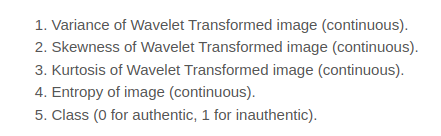

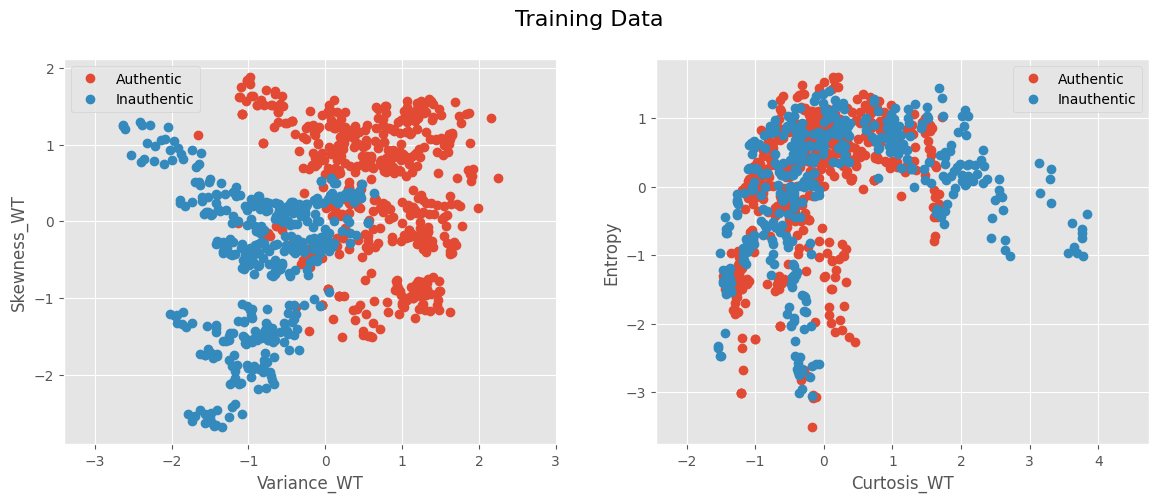

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing_extensions import dataclass_transform

X = pandas_data.iloc[:,:-1].values
y = pandas_data.iloc[:,-1:].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

#Training and Testing Set for classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Training and Testing Set for normalizing flow
X_train_authentic = [X_train[i] for i in range(len(X_train)) if y_train[i]==0]
X_train_inauthentic = [X_train[i] for i in range(len(X_train)) if y_train[i]==1]
X_test_authentic = [X_test[i] for i in range(len(X_test)) if y_test[i]==0]
X_test_inauthentic = [X_test[i] for i in range(len(X_test)) if y_test[i]==1]

banknote_dataset.plotting_data(data_authentic=X_train_authentic, data_inauthentic=X_train_inauthentic, title="Training Data")

In [6]:
from torch.distributions.normal import Normal

# Create the standard normal distribution
y_distribution = Normal(torch.zeros(DATA_DIM, device=DEVICE), torch.ones(DATA_DIM, device=DEVICE))

distribution_sample = [y_distribution.sample().unsqueeze(0).data.cpu().numpy() for x in range(505)]

if (0):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  fig.suptitle("Example Labels in the Standard Normal Disribution", fontsize=16)
  ax1.scatter([item[0,0] for item in distribution_sample], [item[0,1] for item in distribution_sample])
  ax2.scatter([item[0,2] for item in distribution_sample], [item[0,3] for item in distribution_sample])
  plt.show()

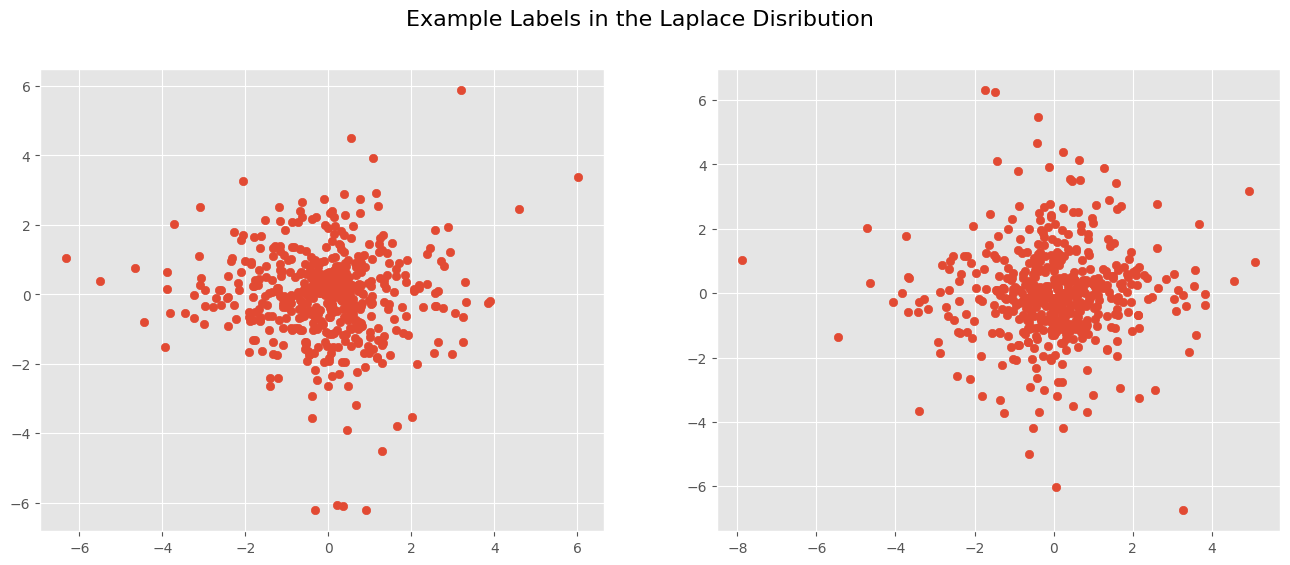

In [7]:
from torch.distributions.laplace import Laplace

# Create the laplace distribution
y_distribution = Laplace(torch.zeros(DATA_DIM, device=DEVICE), torch.ones(DATA_DIM, device=DEVICE))

distribution_sample = [y_distribution.sample().unsqueeze(0).data.cpu().numpy() for x in range(505)]

if (1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle("Example Labels in the Laplace Disribution", fontsize=16)
    ax1.scatter([item[0,0] for item in distribution_sample], [item[0,1] for item in distribution_sample])
    ax2.scatter([item[0,2] for item in distribution_sample], [item[0,3] for item in distribution_sample])
    plt.show()

In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

authentic_flow = train_flow.training(X_train_authentic, device=DEVICE, data_dim=DATA_DIM, y_distribution=y_distribution)
inauthentic_flow = train_flow.training(X_train_inauthentic, device=DEVICE, data_dim=DATA_DIM, y_distribution=y_distribution)

100%|██████████| 60/60 [00:01<00:00, 32.95it/s]


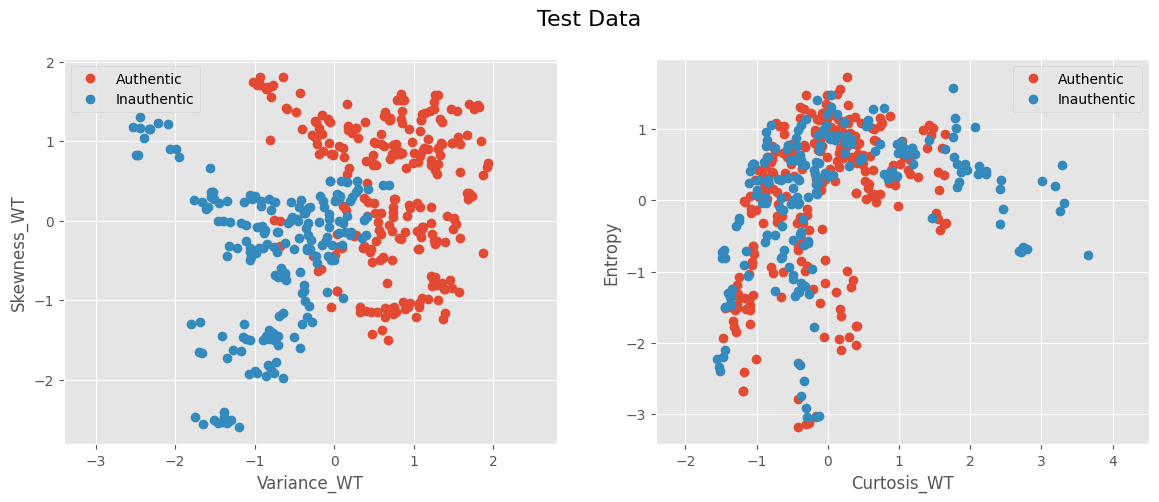

In [9]:
banknote_dataset.plotting_data(data_authentic=X_test_authentic, data_inauthentic=X_test_inauthentic, title="Test Data")

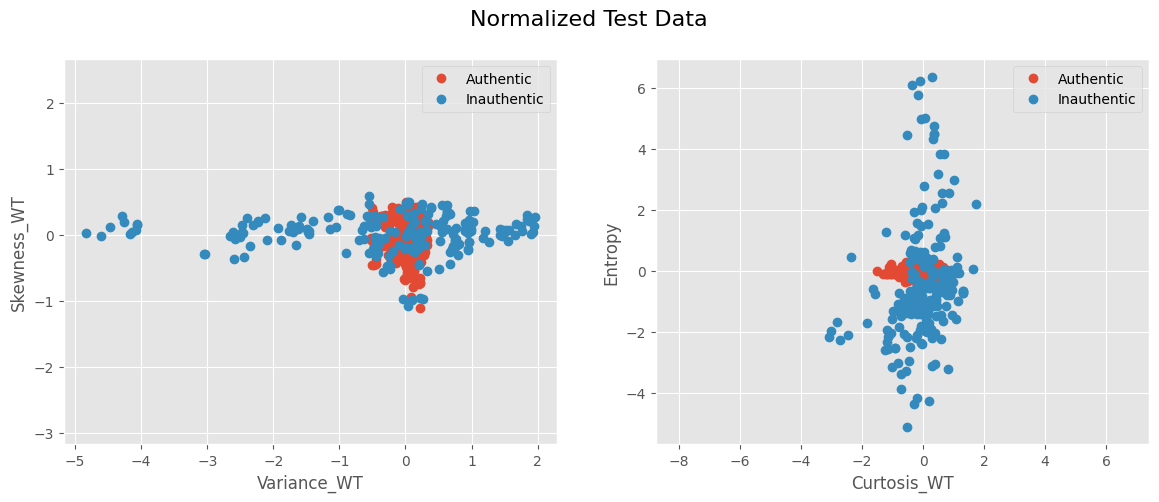

In [10]:
res_auth, jac_auth = authentic_flow.forward(torch.tensor(np.float32(X_test_authentic), device=DEVICE))
res_auth = res_auth.data.cpu().numpy()

res_inauth, jac_inauth = inauthentic_flow.forward(torch.tensor(np.float32(X_test_inauthentic), device=DEVICE))
res_inauth = res_inauth.data.cpu().numpy()

banknote_dataset.plotting_data(data_authentic=res_auth, data_inauthentic=res_inauth, title="Normalized Test Data")

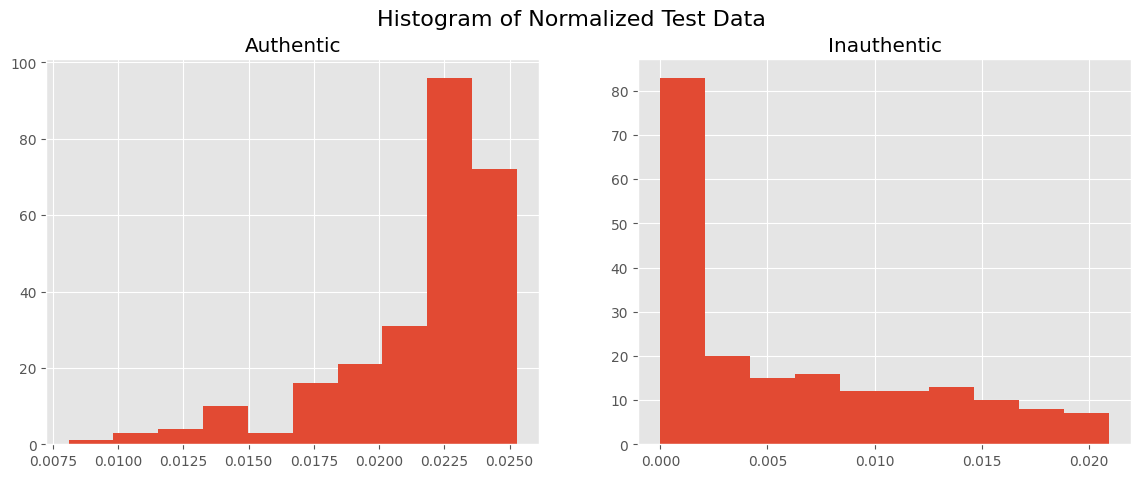

In [11]:
from scipy.stats import multivariate_normal

norm_auth_density = multivariate_normal.pdf(res_auth, mean=np.zeros(DATA_DIM), cov=np.eye(DATA_DIM))
norm_inauth_density = multivariate_normal.pdf(res_inauth, mean=np.zeros(DATA_DIM), cov=np.eye(DATA_DIM))

banknote_dataset.plotting_histogram(norm_auth_density, norm_inauth_density, title="Histogram of Normalized Test Data")

In [12]:
PERCENT_CUT_AUTHENTIC = 0.9
PERCENT_CUT_INAUTHENTIC = 0.9

prob_sum_pairs_authentic = [(norm_auth_density[i], X_test_authentic[i]) for i in range(len(norm_auth_density))]
prob_sum_pairs_inauthentic = [(norm_inauth_density[i], X_test_inauthentic[i]) for i in range(len(norm_inauth_density))]

prob_sum_pairs_authentic.sort(key=lambda x: x[0])
cut = int(PERCENT_CUT_AUTHENTIC * len(norm_auth_density))
prob_sum_pairs_authentic_cut = prob_sum_pairs_authentic[:cut]
prob_sum_pairs_authentic_rest = prob_sum_pairs_authentic[cut:]
prob_sum_pairs_inauthentic.sort(key=lambda x: x[0])
cut = int(PERCENT_CUT_INAUTHENTIC * len(norm_inauth_density))
prob_sum_pairs_inauthentic_cut = prob_sum_pairs_inauthentic[:cut]
prob_sum_pairs_inauthentic_rest = prob_sum_pairs_inauthentic[cut:]

cut_list_authentic = [a[1] for a in prob_sum_pairs_authentic_cut]
rest_list_authentic = [a[1] for a in prob_sum_pairs_authentic_rest]
cut_list_inauthentic = [a[1] for a in prob_sum_pairs_inauthentic_cut]
rest_list_inauthentic = [a[1] for a in prob_sum_pairs_inauthentic_rest]

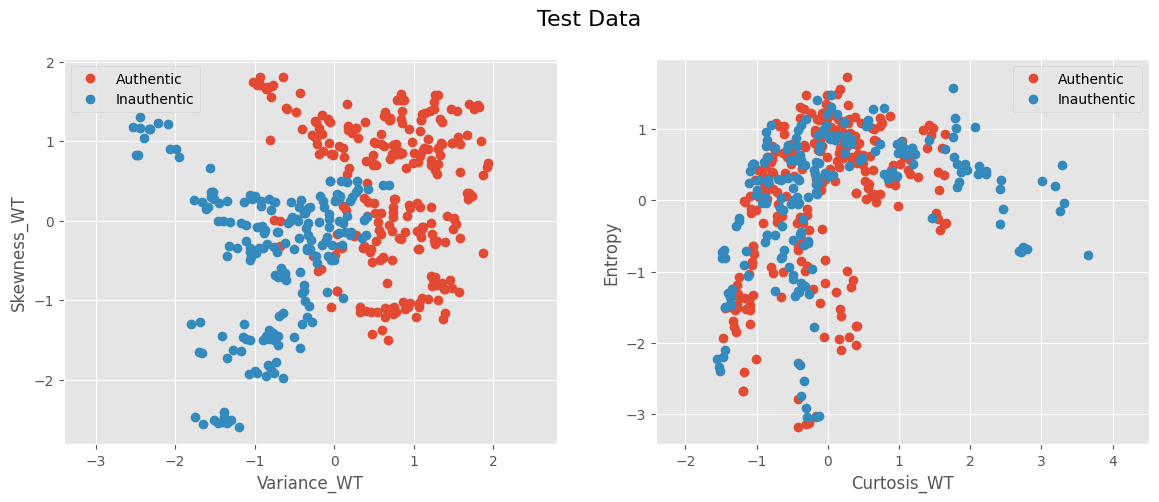

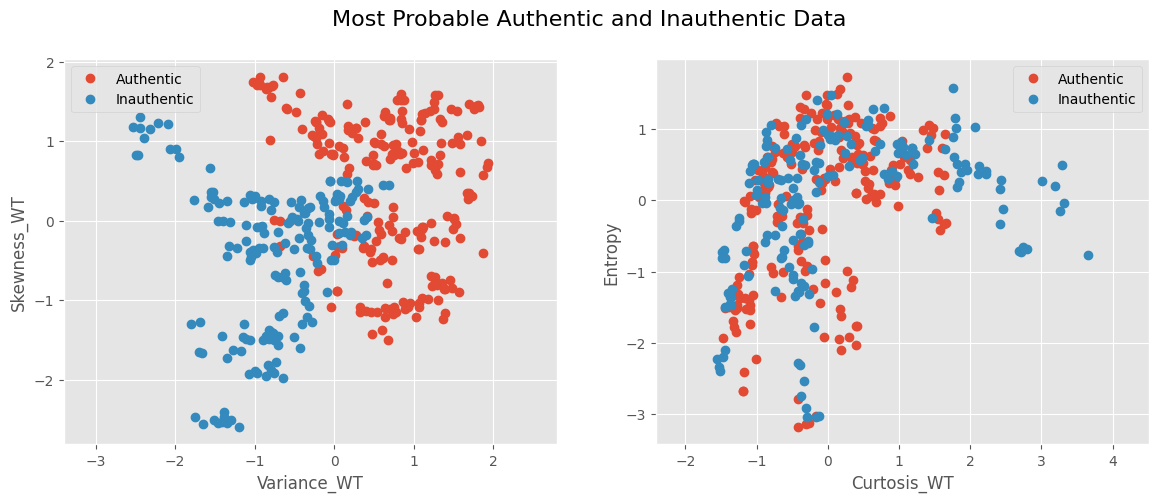

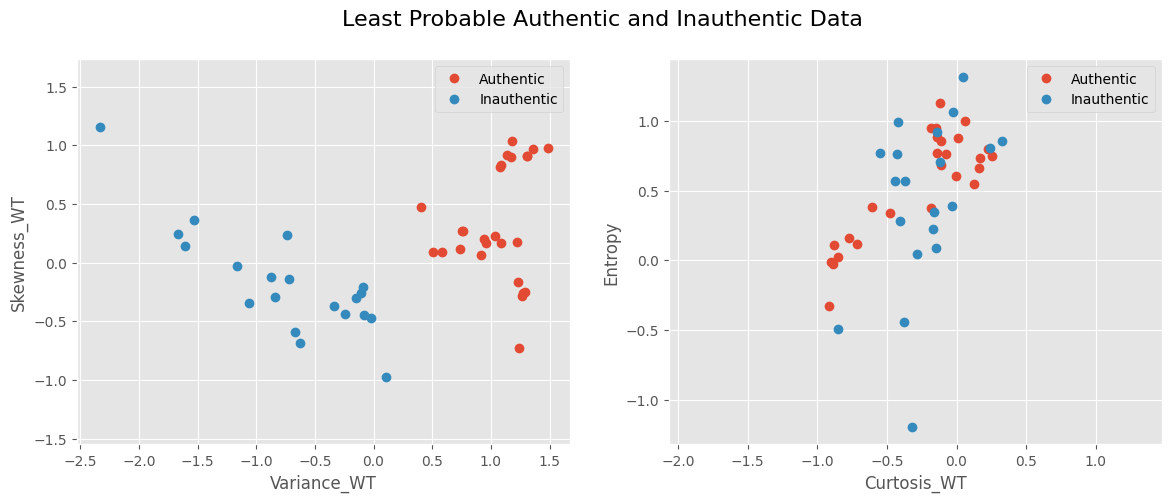

In [13]:
banknote_dataset.plotting_data(data_authentic=X_test_authentic, data_inauthentic=X_test_inauthentic, title="Test Data")
banknote_dataset.plotting_data(data_authentic=cut_list_authentic, data_inauthentic=cut_list_inauthentic, title="Most Probable Authentic and Inauthentic Data")
banknote_dataset.plotting_data(data_authentic=rest_list_authentic, data_inauthentic=rest_list_inauthentic, title="Least Probable Authentic and Inauthentic Data")

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch import sigmoid, tanh
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = nn.Linear(4, 8)  # 4-(8-8)-1
    self.hid2 = nn.Linear(8, 8)
    self.oupt = nn.Linear(8, 1)

    nn.init.xavier_uniform_(self.hid1.weight)
    nn.init.zeros_(self.hid1.bias)
    nn.init.xavier_uniform_(self.hid2.weight)
    nn.init.zeros_(self.hid2.bias)
    nn.init.xavier_uniform_(self.oupt.weight)
    nn.init.zeros_(self.oupt.bias)

  def forward(self, x):
    z = tanh(self.hid1(x)) 
    z = tanh(self.hid2(z))
    z = sigmoid(self.oupt(z))
    return z

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

tensor_x = torch.Tensor(X_train)
tensor_y = torch.Tensor(y_train)

dataset = TensorDataset(tensor_x,tensor_y)

training_loss = []

classifier = Net().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

classifier.train()

# Compute prediction error
pred = classifier(tensor_x.to(DEVICE))
loss = criterion(pred, tensor_y.to(DEVICE))

# Backpropagation
optimizer.zero_grad()
loss.backward()
optimizer.step()
loss = loss.item()

print("acc: " + str(loss))

acc: 0.7497022151947021


In [15]:
import torch 

classifier.eval()

model_filename = "mnist_net.onnx"

# create a dummy input in the shape of the input values
dummy_input = torch.randn(4)
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(classifier,
                  dummy_input,
                  model_filename,
                  export_params=True,
                  verbose=False,
                  )

In [16]:
dummy_input = torch.randn(4)
device = "cuda" if torch.cuda.is_available() else "cpu"
dummy_input = dummy_input.to(device)

torch.onnx.export(authentic_flow,
                    dummy_input,
                    "authentic_flow.onnx",
                    export_params=True,
                    verbose=False,
                    )

torch.onnx.export(inauthentic_flow,
                    dummy_input,
                    "inauthentic_flow.onnx",
                    export_params=True,
                    verbose=False,
                    )

IndexError: too many indices for tensor of dimension 1